# Hands on : introduction to classification with Neural Network

This tutorial will be focused on the classification problem with a toy example: training a neural network classifier to distinguish between two Gaussian distributions.

We will use TensorFlow and Keras to train our neural networks.

After the tutorial, we will learn:
- How to build a neural network model
- How to train a neural network
- How to quantify performance
- How to optimize the model and what is overtraining

## Import Packages

In [1]:
import numpy as np  # numpy is a python package for data processing
import matplotlib.pyplot as plt  # matplotlib is a powerful package for plotting results
from sklearn.model_selection import train_test_split # we use this API from scikit-learn to split the dataset
import tensorflow as tf
# from keras.metrics import AUC

print('Tensorflow version:', tf.__version__)
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

2024-06-21 16:26:29.849480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 16:26:37.289134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.16.1
Num GPUs Available:  0


2024-06-21 16:26:45.871788: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Generate toy data

We want to generate the signal and background samples as two different 2D Gaussian distributions, using `numpy.random.normal`.

The signal is a Gaussian distribution with the mean of (0, 0) and width of 2.

The background is a Gaussian distribution with the mean of (2, 2) and width of 2.

For each distribution, we generate 10K events. 

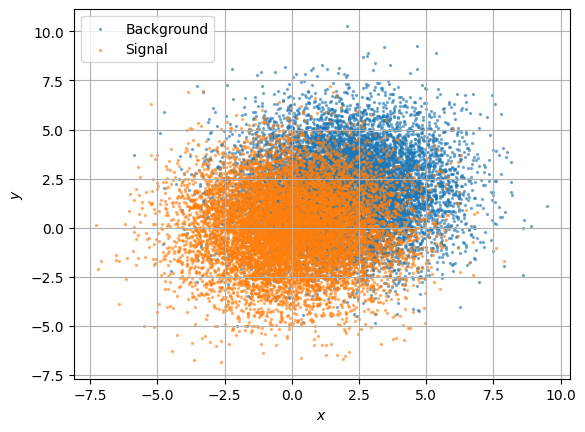

In [9]:
# generate signal sample from a Gaussian of N(0, 2) with 10K events
N_sig = 10000
sigs_x = np.random.normal(0, 2, (N_sig,)) #.astype(dtype=np.float32)
sigs_y = np.random.normal(0, 2, (N_sig,)) #.astype(dtype=np.float32)
sigs = np.stack([sigs_x, sigs_y], axis=1)

# generate background sample from a Gaussian of N(2, 2) with 10K events
N_bkg = 10000
bkgs_x = np.random.normal(2, 2, (N_bkg,)) #.astype(dtype=np.float32)
bkgs_y = np.random.normal(2, 2, (N_bkg,)) #.astype(dtype=np.float32)
bkgs = np.stack([bkgs_x, bkgs_y], axis=1)

# Visualize the signal and background distributions
plt.scatter(bkgs[:, 0], bkgs[:, 1], alpha=0.5, s=2, label='Background', color='tab:blue')
plt.scatter(sigs[:, 0], sigs[:, 1], alpha=0.5, s=2, label='Signal', color='tab:orange')
plt.ylabel(r'$y$')
plt.xlabel(r'$x$')
plt.grid()
plt.legend()
plt.show()

Here, we want to merge the signal and background distribution together into a single dataset. This is what our neural network needs.

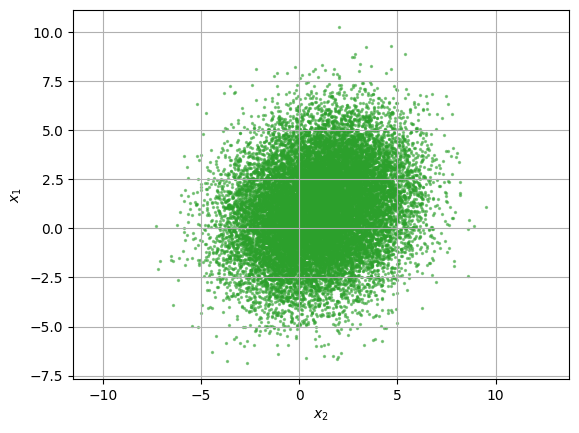

In [10]:
# Merge signal and background together (now we don't know which one is signal which one is background anymore)
input_features = np.concatenate([sigs, bkgs], axis=0)

# Plot input_features
plt.scatter(input_features[:, 0], input_features[:, 1], c='tab:green', alpha=0.5, s=2)
plt.axis('equal')
plt.ylabel(r'$x_1$')
plt.xlabel(r'$x_2$')
plt.grid()
plt.show()

Then, we also need the truth labels for training the neural network.

All of the signal events will be labeled as 1, and background events will be labeled as 0.

In [11]:
sig_labels = np.ones(N_sig)  # Assign label 1 to signals
bkg_labels = np.zeros(N_bkg)  # Assign label 0 to background
truth_labels = np.concatenate([sig_labels, bkg_labels], axis=0)

print('sig_labels:', sig_labels, f', size={len(sig_labels)}')
print('bkg_labels:', bkg_labels, f', size={len(bkg_labels)}')
print('truth_labels:', truth_labels, f', size={len(truth_labels)}')

sig_labels: [1. 1. 1. ... 1. 1. 1.] , size=10000
bkg_labels: [0. 0. 0. ... 0. 0. 0.] , size=10000
truth_labels: [1. 1. 1. ... 0. 0. 0.] , size=20000


## Data splitting

It is very common in machine learning to split data into multiple independent sets, and only use part of the data for training/optimizing the machine learning models, and the rest for testing/evaluating performance.

In the following, we will split the whole data into 50% training set and 50% test set.

We will use the training set to train our neural network and the test set to evaluate the performance of our trained model.

In [13]:
input_features_train, input_features_test, truth_labels_train, truth_labels_test = train_test_split(input_features, truth_labels, test_size=0.5)

print('input_features_train Shape: ', input_features_train.shape)
print('truth_labels_train Shape: ', truth_labels_train.shape)
print('input_features_test Shape: ', input_features_test.shape)
print('truth_labels_test Shape: ', truth_labels_test.shape)

input_features_train Shape:  (10000, 2)
truth_labels_train Shape:  (10000,)
input_features_test Shape:  (10000, 2)
truth_labels_test Shape:  (10000,)


## Training the neural network

In the following, we will use TensorFlow and Keras to build our neural network and train the model.

The architecture is pretty simple: A fully-connected network with 2 hidden layers with the ReLu activation function.
The last layer uses the Sigmoid activation to output the classifier score ranging from 0 to 1.

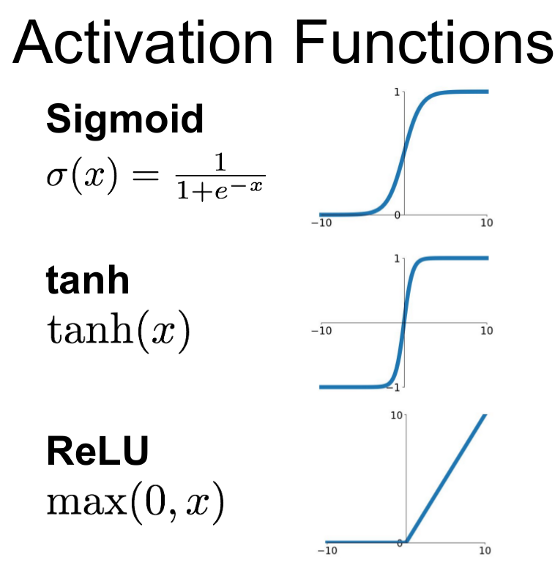

In [14]:
model = tf.keras.models.Sequential(
    [
        tf.keras.Input((input_features_train.shape[1],)), # input layer
        tf.keras.layers.Dense(32, activation='relu'),  # layer 1
        tf.keras.layers.Dense(32, activation='relu'),  # layer 2
        tf.keras.layers.Dense(1, activation='sigmoid'), # last layer
    ]
)
# tanh: tf.keras.activations.tanh

We use the binary cross-entropy as the loss function. Binary cross-entropy is commonly used for the classification problem. The smaller the binary cross-entropy, the closer the prediction is to the truth.

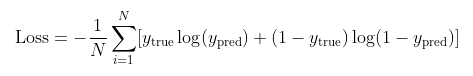

Then we use the SGD (Stochastic gradient descent) optimizer with learning rate = 0.001 to train the model.

In [15]:
model.compile(
    loss='binary_crossentropy',  # use loss='mean_squared_error' for MSE loss
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # use the Adam optimizer instead
    metrics=['AUC'], # monitor AUC for each epoch during the training
)

We train the model with 10 epochs with a batch size of 128.

In [16]:
print('Start training!')

# model.fit() performs the training

the_fit = model.fit(
    input_features_train,
    truth_labels_train,
    epochs=10,
    batch_size=128,
    validation_data=(input_features_test, truth_labels_test),
    # callbacks=[K.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')], # uncomment to use early stopping (should also increase the epochs)
)

Start training!
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.3380 - loss: 0.8244 - val_AUC: 0.3869 - val_loss: 0.7802
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.4129 - loss: 0.7632 - val_AUC: 0.4530 - val_loss: 0.7365
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.4656 - loss: 0.7289 - val_AUC: 0.5156 - val_loss: 0.7060
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5238 - loss: 0.7013 - val_AUC: 0.5690 - val_loss: 0.6842
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.5811 - loss: 0.6770 - val_AUC: 0.6194 - val_loss: 0.6672
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6296 - loss: 0.6644 - val_AUC: 0.6761 - val_loss: 0.6534
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6827 - loss: 0.6497 - val_AUC: 0.7272 - val_loss: 0.6417
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7377 - loss: 0.6344 - val_AUC: 0.7558 - val_loss: 0.6317
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC:

### Plot the training progress

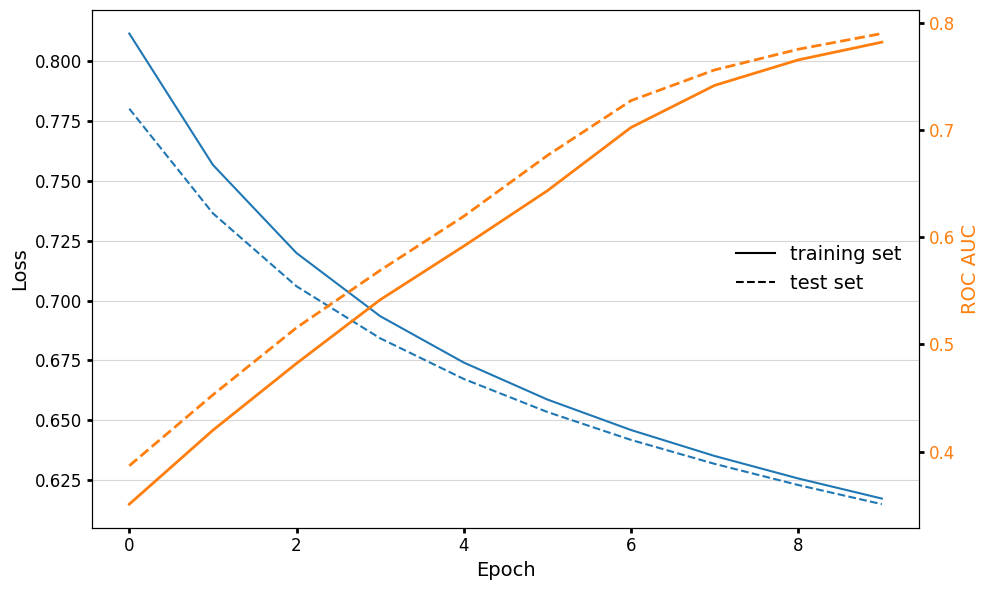

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(the_fit.history['loss'], color='tab:blue')
ax.plot(the_fit.history['val_loss'], color='tab:blue', ls='--')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel('ROC AUC', color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_fit.history['AUC'], color='tab:orange', lw=2)
ax2.plot(the_fit.history['val_AUC'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color='black', label='training set')
ax2.plot([], [], color='black', ls='--', label='test set')
ax2.legend(fontsize=14, frameon=False, loc='right')
fig.tight_layout()

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [20]:
pred_labels_test = model.predict(input_features_test).ravel()
pred_labels_train = model.predict(input_features_train).ravel()

print("pred_labels_test: ", pred_labels_test)
print("pred_labels_train: ", pred_labels_train)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
pred_labels_test:  [0.19317992 0.5291683  0.47251675 ... 0.521755   0.35734332 0.24439776]
pred_labels_train:  [0.533166   0.5312013  0.21600656 ... 0.5052647  0.3626274  0.40235668]


### ROC curves and Area Under the Curve (AUC)

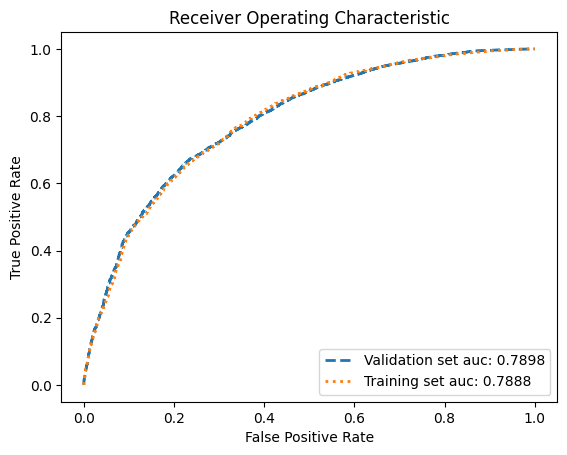

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=truth_labels_test, y_score=pred_labels_test)
fpr_train, tpr_train, _ = roc_curve(y_true=truth_labels_train, y_score=pred_labels_train)
auc_val = roc_auc_score(y_true=truth_labels_test, y_score=pred_labels_test)
auc_train = roc_auc_score(y_true=truth_labels_train, y_score=pred_labels_train)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls='--', label=f'Validation set auc: {auc_val:.4f}')
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=':', label=f'Training set auc: {auc_train:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Plotting NN Score for Signal and Background

Let's check the NN score distribution of the signal and the background. This can visualize how well our neural network is able to separate the signal and background.

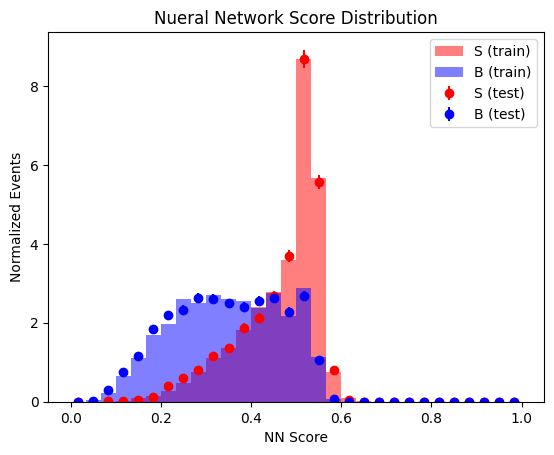

In [22]:
pred_labels_train_sig = pred_labels_train[truth_labels_train == 1]
pred_labels_train_bkg = pred_labels_train[truth_labels_train == 0]

pred_labels_test_sig = pred_labels_test[truth_labels_test == 1]
pred_labels_test_bkg = pred_labels_test[truth_labels_test == 0]

plt.hist(
    pred_labels_train_sig,
    color='r',
    alpha=0.5,
    range=(0, 1),
    bins=30,
    histtype='stepfilled',
    density=True,
    label='S (train)',
)
plt.hist(
    pred_labels_train_bkg,
    color='b',
    alpha=0.5,
    range=(0, 1),
    bins=30,
    histtype='stepfilled',
    density=True,
    label='B (train)',
)

hist, bins = np.histogram(pred_labels_test_sig, bins=30, range=(0, 1), density=True)
scale = len(pred_labels_test_sig) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

hist, bins = np.histogram(pred_labels_test_bkg, bins=30, range=(0, 1), density=True)
scale = len(pred_labels_test_bkg) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

plt.title('Nueral Network Score Distribution')
plt.xlabel('NN Score')
plt.ylabel('Normalized Events')
plt.legend(loc='best')
plt.show()

## What does overtraining look like?

Recipe:
1. Add More layers
2. Add more nodes per layer
3. Train on less data

In [23]:
# Crazy Example
N = len(input_features_train)
n = int(N / 1000) # crazy example!!
print('Using', n, '/', N, 'events')

input_features_train_small = input_features_train[:n]
truth_labels_train_small = truth_labels_train[:n]

Using 10 / 10000 events


In [24]:
ot_model = tf.keras.models.Sequential(
    [
        tf.keras.Input((input_features_train_small.shape[1],)),  # input layer
        tf.keras.layers.Dense(256, activation='relu'),  # 1st hiddden layer
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ]
)
ot_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

the_overfit = ot_model.fit(
    input_features_train_small,
    truth_labels_train_small,
    epochs=50,
    batch_size=128,
    validation_data=(input_features_test, truth_labels_test),
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - AUC: 0.4400 - loss: 0.7052 - val_AUC: 0.8119 - val_loss: 0.6452
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - AUC: 0.9600 - loss: 0.6335 - val_AUC: 0.8345 - val_loss: 0.6038
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - AUC: 1.0000 - loss: 0.5807 - val_AUC: 0.8389 - val_loss: 0.5736
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - AUC: 1.0000 - loss: 0.5377 - val_AUC: 0.8399 - val_loss: 0.5513
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - AUC: 1.0000 - loss: 0.5004 - val_AUC: 0.8400 - val_loss: 0.5358
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - AUC: 0.9800 - loss: 0.4661 - val_AUC: 0.8399 - val_loss: 0.5274
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - AUC: 1.0000 - loss: 0.4354 - val_AUC: 0.8393 - val_loss: 0.5270
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - AUC: 1.0000 - loss: 0.4079 - val_AUC: 0.8387 - val_loss: 0.5350
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - AUC: 1.0000 - loss: 0.3

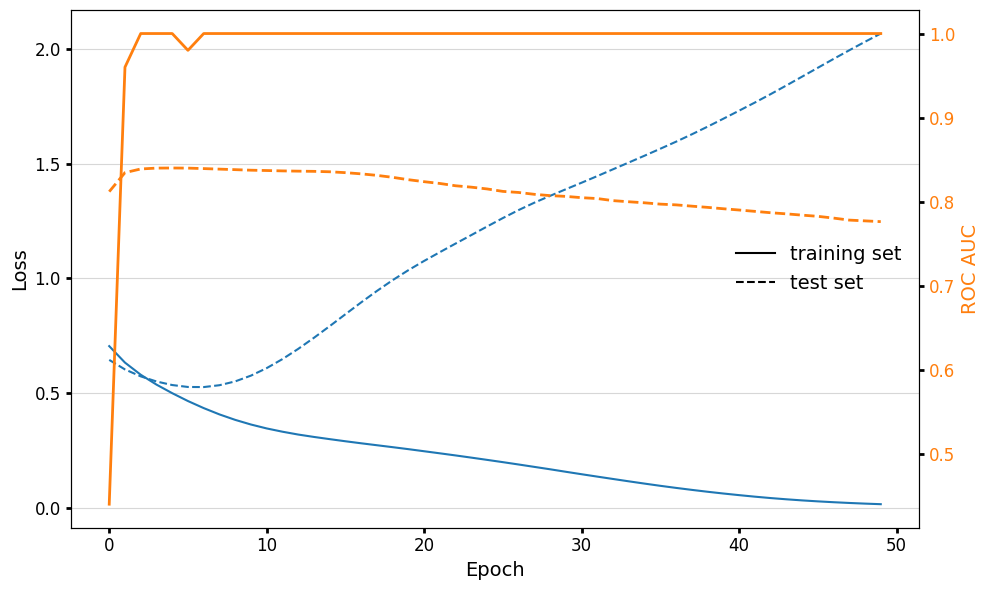

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(the_overfit.history['loss'], color='tab:blue')
ax.plot(the_overfit.history['val_loss'], color='tab:blue', ls='--')
ax.set_xlabel('Epoch', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel('ROC AUC', color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_overfit.history['AUC'], color='tab:orange', lw=2)
ax2.plot(the_overfit.history['val_AUC'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color='black', label='training set')
ax2.plot([], [], color='black', ls='--', label='test set')
ax2.legend(fontsize=14, frameon=False, loc='right')
fig.tight_layout()

In [27]:
ot_pred_labels_test = ot_model.predict(input_features_test).ravel()
ot_pred_labels_train = ot_model.predict(input_features_train_small).ravel()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


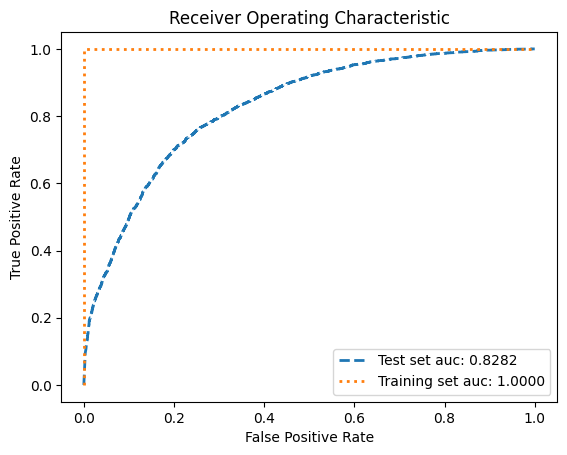

In [28]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=truth_labels_test, y_score=ot_pred_labels_test)
fpr_train, tpr_train, _ = roc_curve(y_true=truth_labels_train_small, y_score=ot_pred_labels_train)
auc_test = roc_auc_score(y_true=truth_labels_test, y_score=ot_pred_labels_test)
auc_train = roc_auc_score(y_true=truth_labels_train_small, y_score=ot_pred_labels_train)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls='--', label=f'Test set auc: {auc_test:.4f}')
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=':', label=f'Training set auc: {auc_train:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Exercises

### Can we try to improve the neural network performance?

Hints:
- Adjust learning rate
- Adjust the number of neurons, and layers
- Increase epochs
- Enable early stopping (and increase max epochs)
- Adjust batch size
- Change activations: [relu, leakyrelu, selu, tanh]
- Try different optimizers (e.g. SGD)
- Dynamic learning rate: e.g. tfa.optimizers.RectifiedAdam as the optimizer, tf.keras.callbacks.ReduceLROnPlateau as a callback
- More... google!

## Please attend the US ATLAS Machine Learning Training Program 2024 for a more dedicated machine learning introduction!!

Indico page: https://indico.physics.lbl.gov/event/2850/